# Fit Pulse
### Fitness Data Analysis Project
>This project was done in regards to Infosys Virtual Internship 6.0
---
Team members involved in this project:

Agilesh Arumugam

# Imports

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from collections import defaultdict
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from typing import Dict, List
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

# Data Loading and Cleaning
Data was taken from Kaggle.

In [38]:
data = pd.read_csv(r'../data/data.csv')

In [39]:
data.columns

Index(['heart_rate', 'time_elapsed', 'distance', 'avg_running_cadence',
       'total_calories', 'speed'],
      dtype='object')

In [40]:
data.dtypes

heart_rate             float64
time_elapsed           float64
distance               float64
avg_running_cadence    float64
total_calories         float64
speed                  float64
dtype: object

In [41]:
data.head()

,heart_rate,time_elapsed,distance,avg_running_cadence,total_calories,speed
0,143.0,486.0,1.61317,80.0,78.0,0.003319
1,154.0,883.0,3.21954,80.0,82.0,0.003646
2,156.0,1317.0,4.83101,80.0,89.0,0.003668
3,143.0,460.0,1.61227,81.0,97.0,0.003505
4,155.0,891.0,3.22219,81.0,102.0,0.003616


In [42]:
categorical_columns = [

]
numerical_columns = list(set(data.columns) - set(categorical_columns))

column_types = {
    'numerical_columns': numerical_columns,
    'categorical_columns': categorical_columns,
}
column_types

{'numerical_columns': ['speed',
  'total_calories',
  'heart_rate',
  'distance',
  'time_elapsed',
  'avg_running_cadence'],
 'categorical_columns': []}

In [43]:
# define a function to clean our data
def clean_data(data: pd.DataFrame, column_types: Dict[str, List]) -> pd.DataFrame:
    for column in data.columns:
        if column in column_types['numerical_columns']:
            data[column] = data[column].astype(np.float64)
            data[column] = data[column].fillna(data[column].mean())
        elif column in column_types['categorical_columns']:
            data[column] = data[column].fillna(data[column].mode()[0])
            data[column] = data[column].astype(str)
    
    return data

In [44]:
# check if nan values or null values are there
def data_needs_cleaning(data: pd.DataFrame):
    print(data.isna().sum())
    return True if data.isna().sum().sum() > 0 else False

if data_needs_cleaning(data):
    data = clean_data(data, column_types)
    print("\nData cleaning done.")
data_needs_cleaning(data)

data['speed'] = data['distance'] / data['time_elapsed']

# save the cleaned data
data.to_csv(r'../data/data.csv', index=False)

heart_rate             0
time_elapsed           0
distance               0
avg_running_cadence    0
total_calories         0
speed                  0
dtype: int64
heart_rate             0
time_elapsed           0
distance               0
avg_running_cadence    0
total_calories         0
speed                  0
dtype: int64


In [45]:
data.head()

,heart_rate,time_elapsed,distance,avg_running_cadence,total_calories,speed
0,143.0,486.0,1.61317,80.0,78.0,0.003319
1,154.0,883.0,3.21954,80.0,82.0,0.003646
2,156.0,1317.0,4.83101,80.0,89.0,0.003668
3,143.0,460.0,1.61227,81.0,97.0,0.003505
4,155.0,891.0,3.22219,81.0,102.0,0.003616


# Mapping strings to numbers

In [46]:
# we only do this if we have gender column in data, in this case, we do not have

'''
gender_string_map = {
    'Male': 0,
    'Female': 1
}
if (data['Gender'].dtype == 'object'):
    data['Gender'] = data['Gender'].map(gender_string_map)

data.head()
'''

"\ngender_string_map = {\n    'Male': 0,\n    'Female': 1\n}\nif (data['Gender'].dtype == 'object'):\n    data['Gender'] = data['Gender'].map(gender_string_map)\n\ndata.head()\n"

# Correlation Matrix

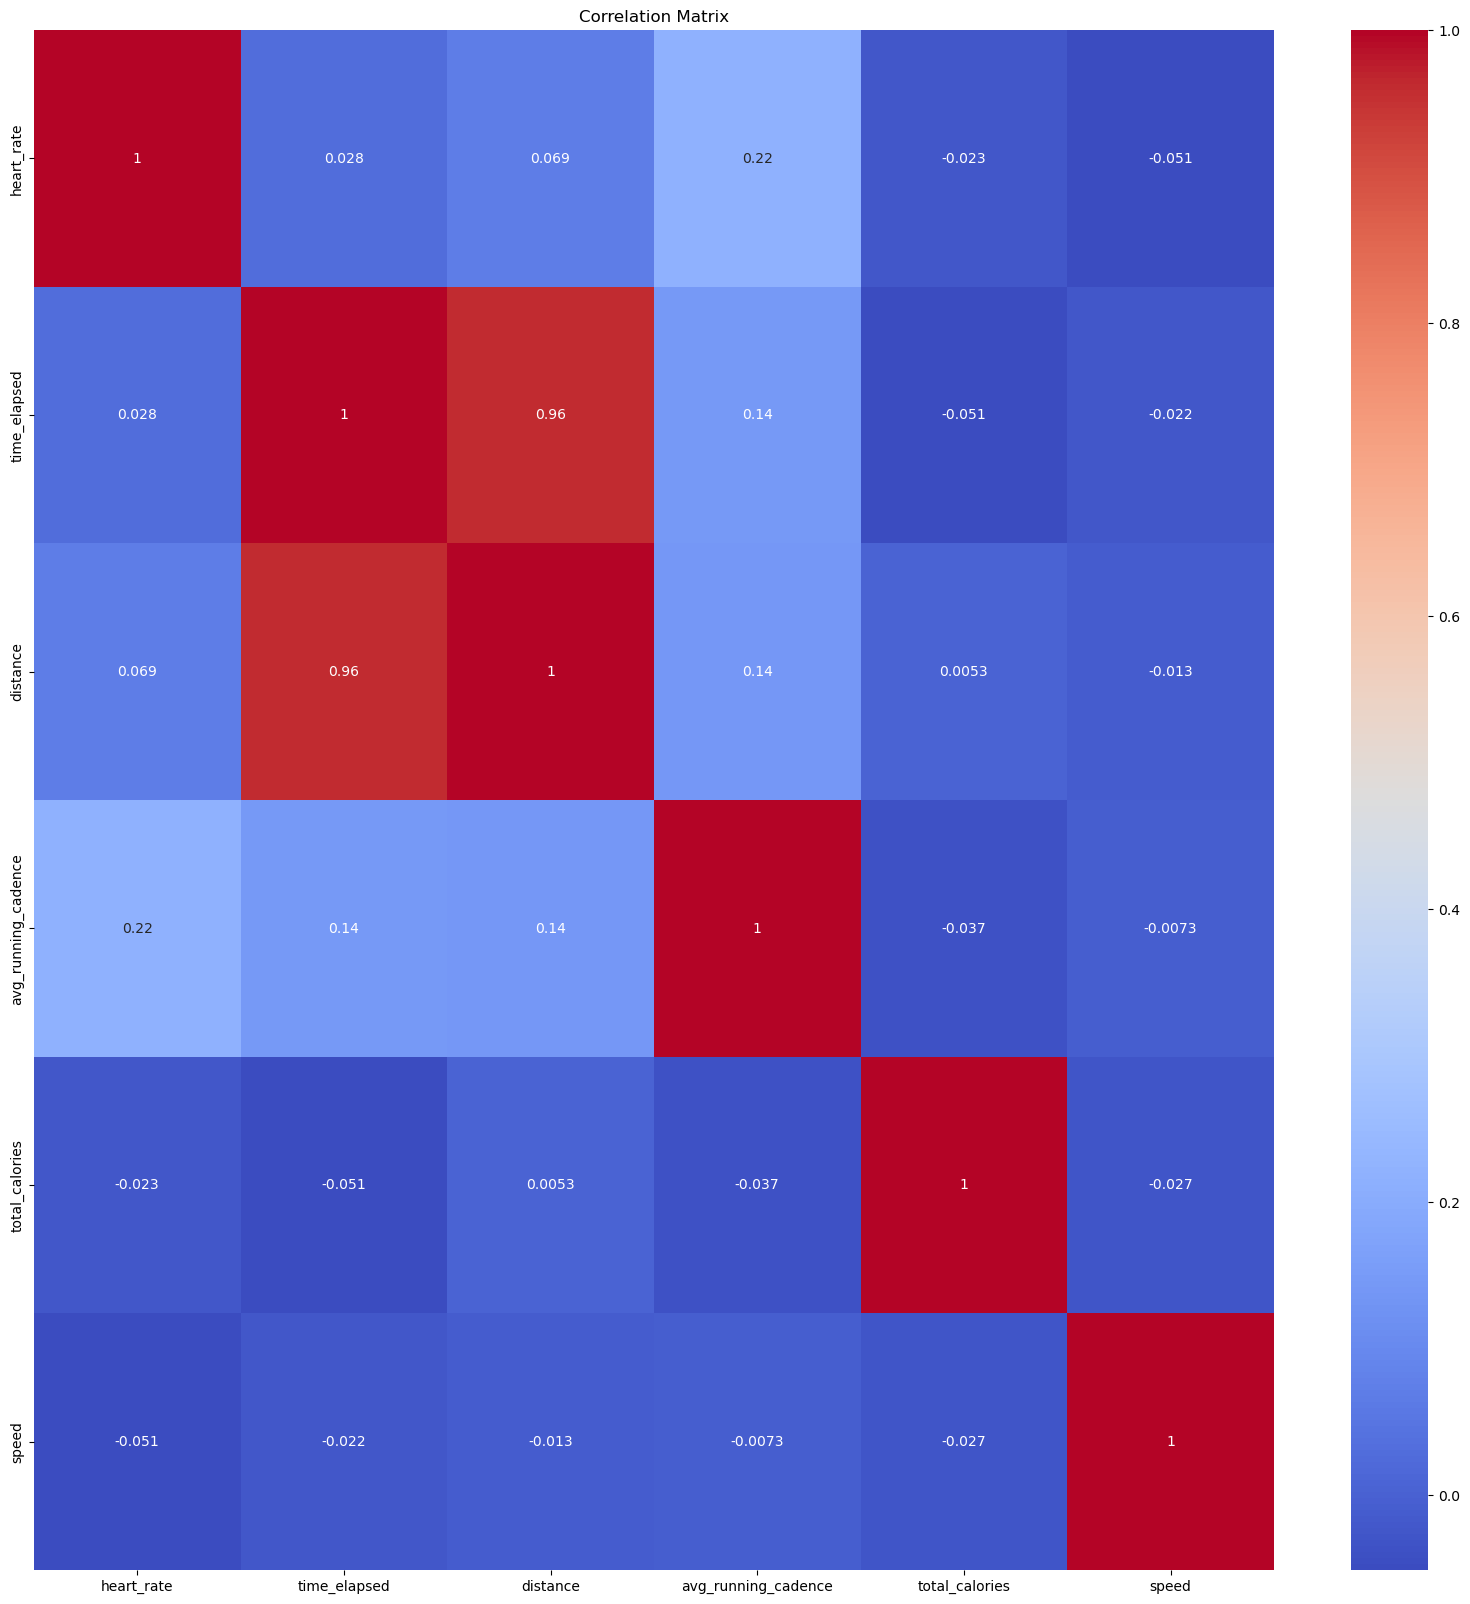

In [47]:
corr = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

### Let's plot the correlations so we know for which variables we need to make visualizations for.

In [48]:
correlations = []
num_columns = len(data.columns)
for i, column in enumerate(data.columns):
    for j in range(i + 1, num_columns):
        correlations.append(corr.loc[column, data.columns[j]])
correlations = np.array(correlations).reshape(-1, 1)
correlations_abs = np.abs(correlations)

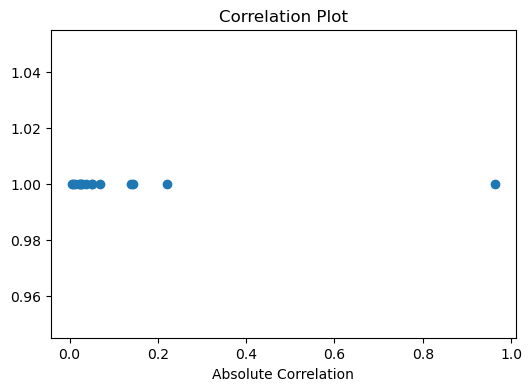

In [49]:
plt.figure(figsize=(6, 4))
plt.scatter(correlations_abs, [1] * len(correlations_abs))
plt.title("Correlation Plot")
plt.xlabel("Absolute Correlation")
plt.show()

# we notice correlations with absolute value above 0.2 is a good threshold to filter out badly correlating varaibles

In [50]:
highly_corr_vars = defaultdict(list)
for i, column in enumerate(data.columns):
    for j in range(i + 1, num_columns):
        ijth_correlation = corr.loc[column, data.columns[j]]
        if abs(ijth_correlation) > 0.2:
            highly_corr_vars['var_1'].append(column)
            highly_corr_vars['var_2'].append(data.columns[j])
            highly_corr_vars['corr'].append(ijth_correlation)
highly_corr_vars = pd.DataFrame(highly_corr_vars)

# Visualise the highly correlating variables.

In [51]:
num_highly_corr_vars = len(highly_corr_vars)
for i in range(num_highly_corr_vars):
    var_1, var_2, corr = highly_corr_vars.iloc[i].var_1, highly_corr_vars.iloc[i].var_2, highly_corr_vars.iloc[i].corr
    
    fig = px.scatter(data, var_2, var_1)
    fig.show()

### Let's fit a regression line between distance and time_elapsed

In [52]:
# let dt stand for distance-time

dt_x = data[['distance']]
dt_y = data[['time_elapsed']]

dt_x_train, dt_x_test, dt_y_train, dt_y_test = train_test_split(dt_x, dt_y, test_size=0.3)
dt_model = LinearRegression()
dt_model.fit(dt_x_train, dt_y_train)
dt_pred = dt_model.predict(dt_x_test)
dt_prediction_results = pd.DataFrame(
    {
        'x': dt_x_test['distance'].to_list(),
        'y_pred': dt_pred.reshape(-1),
        'y_true': dt_y_test['time_elapsed'].to_list()
    }
)

In [53]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=dt_prediction_results['x'],
    y=dt_prediction_results['y_pred'],
    mode='lines',
    name='Predicted'
))

fig.add_trace(go.Scatter(
    x=dt_prediction_results['x'],
    y=dt_prediction_results['y_true'],
    mode='markers',
    name='True',
    opacity=0.3
))

fig.update_layout(
    title="Predicted vs True (Distance-Time)",
    xaxis_title="Distance",
    yaxis_title="Time Elapsed"
)

fig.show()

# Plotting All Relationships

In [54]:
fig = px.scatter_matrix(
    data,
    dimensions=list(data.columns),   # columns to include
    height=1080, width=1080
)
fig.update_traces(marker=dict(size=4, opacity=0.6))
fig.update_layout(title="Scatter matrix (pairwise)")
fig.show()

# Clustering time_elapsed vs total_calories.

In [55]:
# let tc stand for time-calories

tc = []
for i in range(len(data)):
    tc.append((data['time_elapsed'].iloc[i], data['total_calories'].iloc[i]))
tc = np.array(tc)

tc_scaled = StandardScaler().fit_transform(tc)
km = KMeans(n_clusters=3, init='k-means++', random_state=123, n_init=50)
clusters = km.fit_predict(tc_scaled)

tc_plot_data = pd.DataFrame(
    {
        'x': tc_scaled[..., 0],
        'y': tc_scaled[..., 1]
    }
)

In [56]:
fig = px.scatter(tc_plot_data, 'x', 'y', color=clusters)
fig.show()

# Anomaly Detection

In [57]:
x_data = data.loc[:, ['heart_rate', 'time_elapsed', 'avg_running_cadence', 'total_calories']]
y_data = data.loc[:, ['distance']]
data_numpy = np.hstack([x_data.to_numpy(), y_data.to_numpy()])
print(data_numpy.shape)

(5623, 5)


In [58]:
mu = np.mean(data_numpy, axis=0 )
cov = np.cov(data_numpy, rowvar=False)

In [59]:
def flag_anomaly(mu, cov, x_star):
    inv_cov = np.linalg.inv(cov)
    d = np.sqrt((x_star - mu).T @ inv_cov @ (x_star - mu))
    if d >= 3:
        print("The given data is an anomaly.")
        return True
    return False

In [60]:
flag_anomaly(mu, cov, np.array([0, 0, 0, 0, 0]))

The given data is an anomaly.


True